In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
import joblib
import numpy as np
import sys
sys.path.append('../scrape.py')
import scrape

dataset = pd.read_csv('../../Dataset/Merged/MergedDataset.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Dataset di train:
(1593, 5588)
I malati sono:  695
I sani sono:  898

Dataset di test:
(520, 5588)
I malati sono:  245
I sani sono:  275


In [2]:
def load_files_to_dataframes(directory, geneList, file_extension='.txt'):
    dataframes = {}
    
    for name in geneList:
        print(name)
        filename = name+'.tab3.txt'
        if filename in os.listdir(directory):
            print("File presente, caricamento in corso...")
            if filename.endswith(file_extension):
                file_path = os.path.join(directory, filename)
        else:
            print("File non presente")
            scrape.main(name)

        df = pd.read_csv(file_path, delimiter='\t')[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
        df['Interaction'] = df.apply(
        lambda row: '_'.join(sorted([row['Official Symbol Interactor A'], row['Official Symbol Interactor B']])), axis=1)
        dataframes[filename] = df

    return dataframes

In [39]:
expl = joblib.load('../../ShapValues/DatasetFull/ensemble_expl.pkl')
expl_summary = np.abs(expl).mean(0)
expl_dictSummary = dict(zip(x_train.columns, expl_summary))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

ensemble_ablation = joblib.load("../../ShapValues/DatasetFull/ensembleSoft_ablationScores.pkl")
ensemble_sorted_scores = dict(sorted(ensemble_ablation.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures = {key: value for key, value in ensemble_sorted_scores.items() if value > 1.0}

Biogrid interactions su 50 migliori ensemble

RPL23
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
ALDOA
File presente, caricamento in corso...
GIT2
File presente, caricamento in corso...
SKI
File presente, caricamento in corso...
ARHGAP4
File presente, caricamento in corso...
ZNF223
File presente, caricamento in corso...
DDX6
File presente, caricamento in corso...
DPYSL2
File presente, caricamento in corso...
ASAH1
File presente, caricamento in corso...
USP25
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
TXNL1
File presente, caricamento in corso...
EEF1A1
File presente, caricamento in corso...
IL18
File presente, caricamento in corso...
HLA-DMB
File presente, caricamento in corso...
SEMA4D
File presente, caricamento in corso...
HLA-DRB5
File presente, caricamento in corso...
ITPR3
File presente, caricamento in corso...
UTY
File presente, caricamento in corso...
PPT1
File presente, caricamento in corso...
ZNF91
File presente, caricamento in corso...
RENB

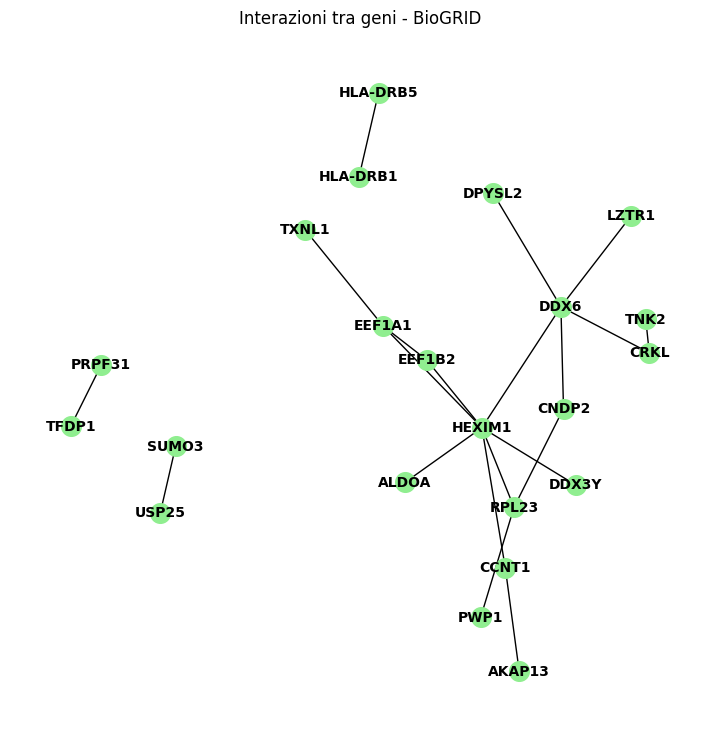

In [41]:
geneList = list(expl_sorted.keys())[:50]
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)

# Crea un grafo non orientato
G = nx.Graph()

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G, k=0.5)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - BioGRID')
plt.show()

Di questi sono noti:
<br> AKAP13
<br> HLA-DMB
<br> HLA-DRB1
<br> HLA-DRB5

Grafo ottenuto da matrice di correlazione fatta su explanation

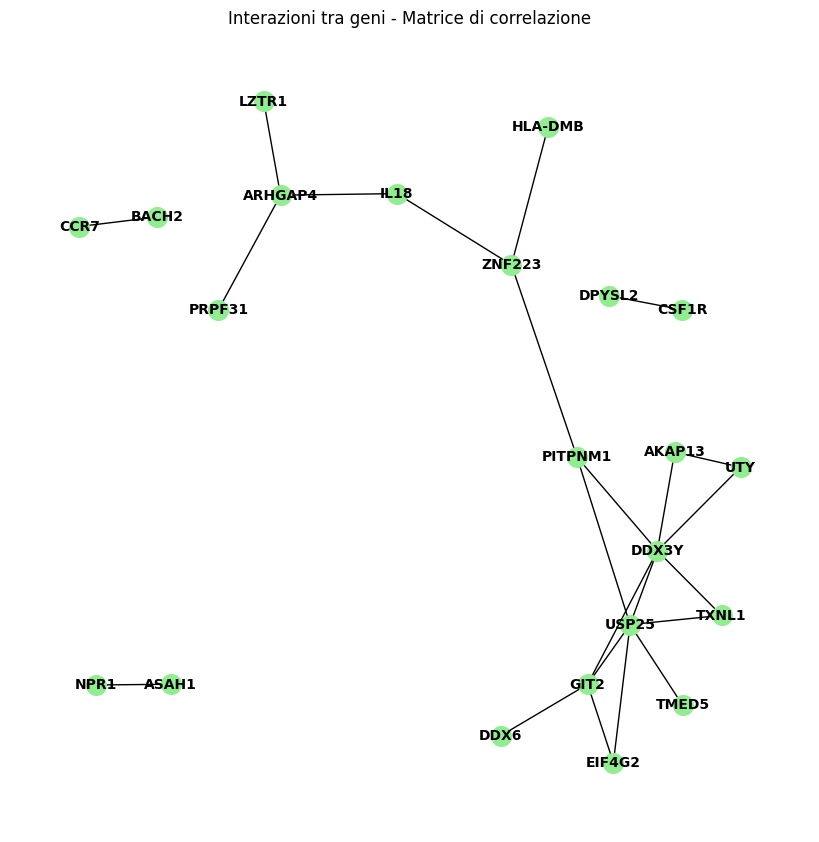

In [42]:
ensembleCorr = pd.DataFrame(expl, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()

G = nx.Graph()

for i in range(ensembleCorr.shape[0]):
    for j in range(ensembleCorr.shape[1]):
        if abs(ensembleCorr.iloc[i, j]) > 0.35 and i != j:
            G.add_edge(ensembleCorr.columns[i], ensembleCorr.columns[j])

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.5)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.show()

Grafo ottenuto da interazioni delle migliori feature per ablation

['HLA-DRB1', 'GIT2', 'NLK', 'DDX17', 'HDAC9', 'UEVLD', 'LAPTM4B', 'UTP14A', 'USP25', 'ESRRA', 'CCNT1', 'VAPB', 'SAFB', 'NPAS3', 'ZNF223', 'HBD', 'DDX6', 'WRNIP1', 'USP33', 'FBLN2', 'SUMO4', 'TSPAN32', 'TGFBRAP1', 'SPOCK2', 'AQP9', 'DDX3Y', 'PAK2', 'PRKAG2', 'SMARCB1', 'HEXIM1']
HLA-DRB1
File presente, caricamento in corso...
GIT2
File presente, caricamento in corso...
NLK
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
HDAC9
File presente, caricamento in corso...
UEVLD
File presente, caricamento in corso...
LAPTM4B
File presente, caricamento in corso...
UTP14A
File presente, caricamento in corso...
USP25
File presente, caricamento in corso...
ESRRA
File presente, caricamento in corso...
CCNT1
File presente, caricamento in corso...
VAPB
File presente, caricamento in corso...
SAFB
File presente, caricamento in corso...
NPAS3
File presente, caricamento in corso...
ZNF223
File presente, caricamento in corso...
HBD
File presente, caricamento in corso...
D

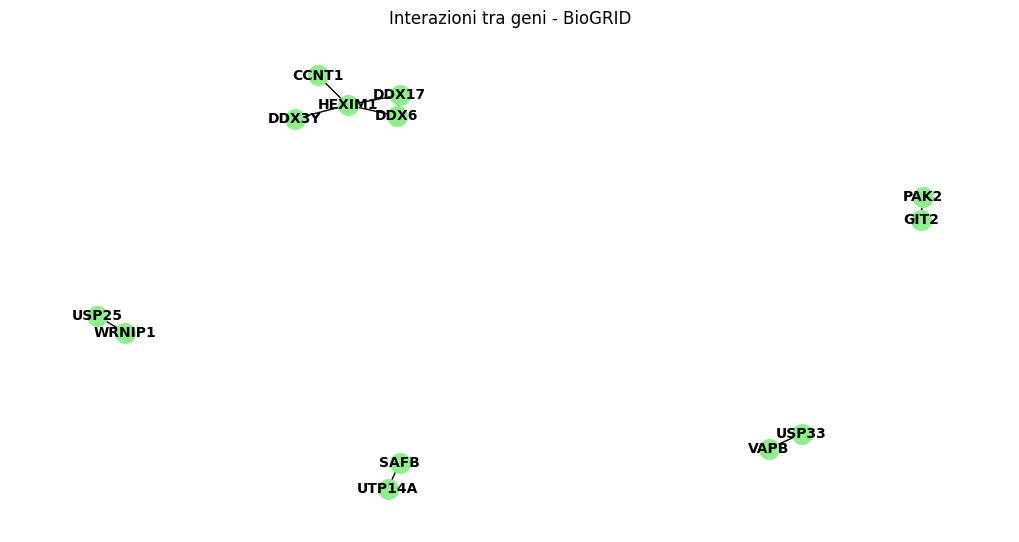

In [43]:
geneList = list(ensemble_bestFeatures.keys())
print(geneList)

dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)

# Crea un grafo non orientato
G = nx.Graph()

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList and gene_a != gene_b:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - BioGRID')
plt.show()

Grafo ottenuto dalla matrice di correlazione con importance data da intersezione ablation e migliori 100 ensemble

{'USP25', 'FBLN2', 'HLA-DRB1', 'GIT2', 'DDX6', 'SPOCK2', 'PAK2', 'DDX17', 'NPAS3', 'DDX3Y', 'AQP9', 'HEXIM1', 'WRNIP1', 'HBD', 'ZNF223', 'NLK', 'CCNT1'}
             USP25     FBLN2  HLA-DRB1      GIT2      DDX6    SPOCK2  \
USP25     1.000000 -0.016227 -0.143557  0.541810  0.231236  0.205416   
FBLN2    -0.016227  1.000000 -0.058925 -0.016663  0.000220 -0.019467   
HLA-DRB1 -0.143557 -0.058925  1.000000 -0.105344 -0.123783  0.048061   
GIT2      0.541810 -0.016663 -0.105344  1.000000  0.357739  0.144839   
DDX6      0.231236  0.000220 -0.123783  0.357739  1.000000  0.120316   
SPOCK2    0.205416 -0.019467  0.048061  0.144839  0.120316  1.000000   
PAK2      0.069080 -0.024046 -0.031381 -0.021669  0.102887  0.091021   
DDX17     0.029317 -0.007334  0.004450  0.030466 -0.007858 -0.086561   
NPAS3     0.188915  0.072560 -0.164142  0.069913  0.076776  0.059609   
DDX3Y     0.600461  0.063443 -0.256978  0.459594  0.334040  0.173070   
AQP9      0.139012  0.019455  0.039958  0.086317  0.106

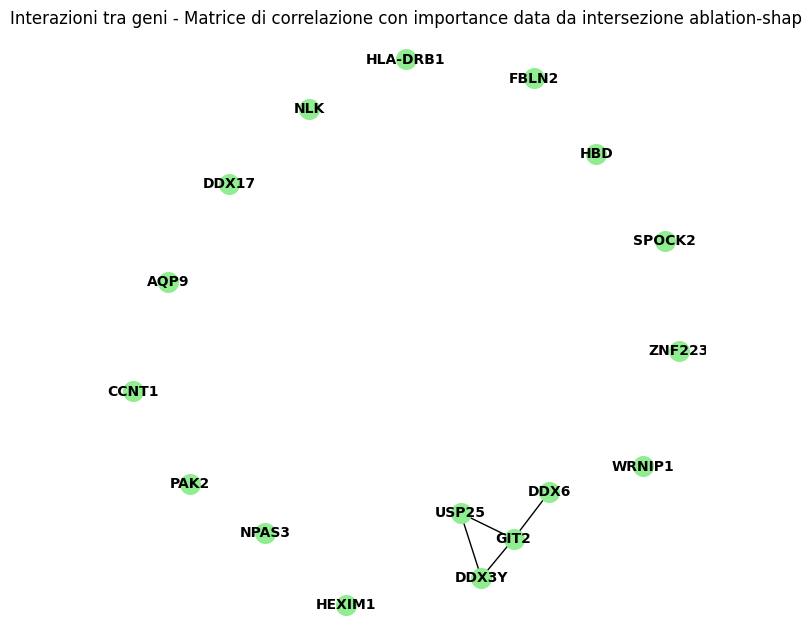

In [44]:
intersect = set(list(ensemble_bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:100]))

print(intersect)

intersectCorr = pd.DataFrame(expl, columns=x_train.columns)[list(intersect)].corr()

print(intersectCorr)

G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    G.add_node(intersectCorr.columns[i])
    for j in range(intersectCorr.shape[1]):
        if abs(intersectCorr.iloc[i, j]) > 0.35 and i != j:
            print(intersectCorr.columns[i], intersectCorr.columns[j])
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j])

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, k=0.5)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - Matrice di correlazione con importance data da intersezione ablation-shap')
plt.show()

Grafo ottenuto da intersezione dei migliori 100 ensemble e migliori ablation

{'USP25', 'FBLN2', 'HLA-DRB1', 'GIT2', 'DDX6', 'SPOCK2', 'PAK2', 'DDX17', 'NPAS3', 'DDX3Y', 'AQP9', 'HEXIM1', 'WRNIP1', 'HBD', 'ZNF223', 'NLK', 'CCNT1'}
USP25
File presente, caricamento in corso...
FBLN2
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
GIT2
File presente, caricamento in corso...
DDX6
File presente, caricamento in corso...
SPOCK2
File presente, caricamento in corso...
PAK2
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
NPAS3
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
AQP9
File presente, caricamento in corso...
HEXIM1
File presente, caricamento in corso...
WRNIP1
File presente, caricamento in corso...
HBD
File presente, caricamento in corso...
ZNF223
File presente, caricamento in corso...
NLK
File presente, caricamento in corso...
CCNT1
File presente, caricamento in corso...


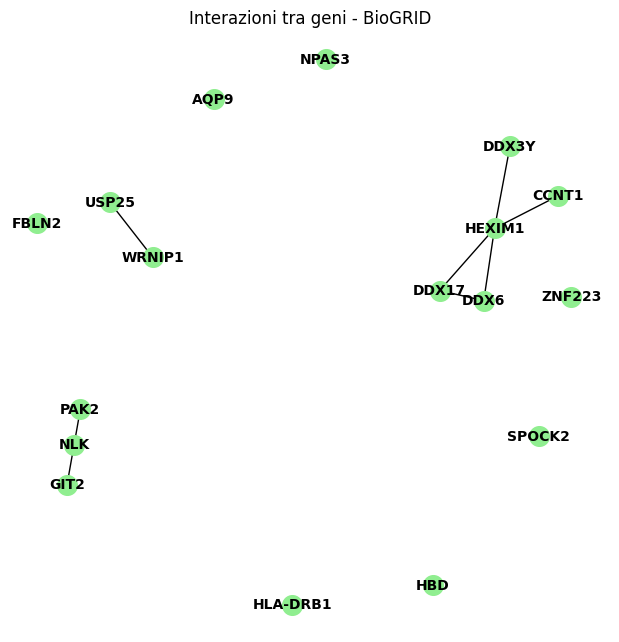

In [47]:
intersect = set(list(ensemble_bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:100]))

print(intersect)

geneList = list(intersect)
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []


i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

G = nx.Graph()

for node in geneList:
    G.add_node(node)

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    G.add_node(gene_a)
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, k=0.5)  # Posizioni dei nodi per il layout
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='black')
plt.title('Interazioni tra geni - BioGRID')
plt.show()